In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
     AddMissingIndicator,
     MeanMedianImputer,
     CategoricalImputer
)


from feature_engine.encoding import (
     RareLabelEncoder,
     OrdinalEncoder,
     OneHotEncoder,
)


from imblearn.under_sampling import RandomUnderSampler

# #XGboost classifier
from xgboost import XGBClassifier


#import PCA
from sklearn.decomposition import PCA

#one hot encoding
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

from helpers import MongoDAO
from datetime import datetime

In [2]:
#Load data
mongo = MongoDAO('admin', 'admin', 'localhost', 27017)
mongo.set_db('bra_paralelo')
mongo.set_collection('feature_store')
account_store_collection = mongo.get_collection()

In [3]:
df = pd.DataFrame(list(account_store_collection.find()))

ServerSelectionTimeoutError: localhost:27017: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente, Timeout: 30s, Topology Description: <TopologyDescription id: 62fa3e2d8c055e1893a02c0f, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente')>]>

In [8]:
print(df.shape)

df.head()

(14641, 17)


,_id,account_id,churn,ltv,months,product,channel,date_of_birth,country,post,like,adview,message,reply,newfriend,dislike,unfriend
0,62f98647a101fb33dedd2c23,1,0,49.95,5,standard,appstore2,1948-09-10,CN,329.0,323.0,184.0,123.0,59.0,57.0,25.0,1.0
1,62f98647a101fb33dedd2c24,2,0,49.95,5,standard,appstore1,1952-11-06,AU,340.0,207.0,117.0,33.0,8.0,30.0,388.0,1.0
2,62f98647a101fb33dedd2c25,3,0,49.95,5,standard,appstore1,2002-11-10,GB,303.0,793.0,1043.0,95.0,26.0,38.0,88.0,3.0
3,62f98647a101fb33dedd2c26,4,0,49.95,5,standard,appstore1,1976-06-18,US,140.0,434.0,135.0,201.0,39.0,55.0,160.0,1.0
4,62f98647a101fb33dedd2c27,5,0,49.95,5,standard,appstore1,1975-11-18,KR,21.0,46.0,66.0,54.0,8.0,3.0,16.0,2.0


In [9]:
#criando variavel idade
year_now = datetime.now().year
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['idade']  = df.date_of_birth.apply(lambda x: year_now -  x.year)

In [10]:
df.head()

,_id,account_id,churn,ltv,months,product,channel,date_of_birth,country,post,like,adview,message,reply,newfriend,dislike,unfriend,idade
0,62f98647a101fb33dedd2c23,1,0,49.95,5,standard,appstore2,1948-09-10,CN,329.0,323.0,184.0,123.0,59.0,57.0,25.0,1.0,74
1,62f98647a101fb33dedd2c24,2,0,49.95,5,standard,appstore1,1952-11-06,AU,340.0,207.0,117.0,33.0,8.0,30.0,388.0,1.0,70
2,62f98647a101fb33dedd2c25,3,0,49.95,5,standard,appstore1,2002-11-10,GB,303.0,793.0,1043.0,95.0,26.0,38.0,88.0,3.0,20
3,62f98647a101fb33dedd2c26,4,0,49.95,5,standard,appstore1,1976-06-18,US,140.0,434.0,135.0,201.0,39.0,55.0,160.0,1.0,46
4,62f98647a101fb33dedd2c27,5,0,49.95,5,standard,appstore1,1975-11-18,KR,21.0,46.0,66.0,54.0,8.0,3.0,16.0,2.0,47


In [11]:
df_aux = pd.DataFrame({
    'columns': df.columns,
    'dtypes': df.dtypes,
    'missing': df.isnull().sum(),
    'missing_percentage': (df.isnull().sum() / df.shape[0]) * 100

})

In [12]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(['churn'],axis=1),df['churn'],test_size=0.2,random_state=0)

In [13]:
#Balanceamento do dataset
under_sample = RandomUnderSampler(random_state=42)
X_train, y_train = under_sample.fit_resample(X_train, y_train)
X_test, y_test = under_sample.fit_resample(X_test, y_test)


In [14]:
arr_columns_drop = ['_id','account_id','months','product','date_of_birth']

X_train.drop(arr_columns_drop,axis=1,inplace=True)
X_test.drop(arr_columns_drop,axis=1,inplace=True)


##### Impute missing values

In [15]:
NUM_FREQUENT_INPUTATIONS =  df_aux.missing_percentage[(df_aux.missing_percentage > 0) & (df_aux['dtypes'] == 'float64')].index.tolist()

In [16]:
NUM_FREQUENT_INPUTATIONS

['post',
 'like',
 'adview',
 'message',
 'reply',
 'newfriend',
 'dislike',
 'unfriend']

In [17]:
CATEGORICAL_INPTUTATIONS = df_aux.missing_percentage[(df_aux.missing_percentage > 0) & (df_aux['dtypes'] == 'object')].index.tolist()

In [18]:
CATEGORICAL_INPTUTATIONS

['country']

In [19]:
median_imputer = MeanMedianImputer(imputation_method='median', variables=NUM_FREQUENT_INPUTATIONS)

# fit the imputer
X_train = median_imputer.fit_transform(X_train)
X_test = median_imputer.fit_transform(X_test)


In [20]:
categorical_imputer = CategoricalImputer(imputation_method='frequent', variables=CATEGORICAL_INPTUTATIONS)
X_train = categorical_imputer.fit_transform(X_train)
X_test = categorical_imputer.fit_transform(X_test)


In [21]:
pd.DataFrame({
    'columns': X_train.columns,
    'dtypes': X_train.dtypes,
    'missing': X_train.isnull().sum(),
    'missing_percentage': (X_train.isnull().sum() / X_train.shape[0]) * 100

})

,columns,dtypes,missing,missing_percentage
ltv,ltv,float64,0,0.0
channel,channel,object,0,0.0
country,country,object,0,0.0
post,post,float64,0,0.0
like,like,float64,0,0.0
adview,adview,float64,0,0.0
message,message,float64,0,0.0
reply,reply,float64,0,0.0
newfriend,newfriend,float64,0,0.0
dislike,dislike,float64,0,0.0


In [22]:
NUM_VARS_TO_NORMALIZE = X_train.columns[(X_train.dtypes == 'float64')].tolist()

In [23]:
NUM_VARS_TO_NORMALIZE = NUM_VARS_TO_NORMALIZE + ['idade']

In [24]:
NUM_VARS_TO_NORMALIZE

['ltv',
 'post',
 'like',
 'adview',
 'message',
 'reply',
 'newfriend',
 'dislike',
 'unfriend',
 'idade']

In [25]:
min_max_scaler = MinMaxScaler()

for var in NUM_VARS_TO_NORMALIZE:
    X_train[var] = min_max_scaler.fit_transform(X_train[[var]])
    X_test[var] = min_max_scaler.fit_transform(X_test[[var]])


In [26]:
#RARE LABELS
CAT_VARS_RARE_LABELS = X_train.columns[(X_train.dtypes == 'object')].tolist()

In [27]:
CAT_VARS_RARE_LABELS

['channel', 'country']

In [28]:
rare_label_encoder = RareLabelEncoder(variables=CAT_VARS_RARE_LABELS, tol=0.05,n_categories=10)
X_train = rare_label_encoder.fit_transform(X_train)
X_test = rare_label_encoder.transform(X_test)


In [29]:
#OneHotEncoder
CAT_VARS_ONE_HOT_ENCODER = X_train.columns[(X_train.dtypes == 'object')].tolist()


In [30]:
CAT_VARS_ONE_HOT_ENCODER

['channel', 'country']

In [31]:
from feature_engine.encoding import OneHotEncoder

one_hot_encoder = OneHotEncoder( variables=CAT_VARS_ONE_HOT_ENCODER, drop_last=False, top_categories=6)

X_train = one_hot_encoder.fit_transform(X_train)
X_test = one_hot_encoder.transform(X_test)

In [32]:
X_train

,ltv,post,like,adview,message,reply,newfriend,dislike,unfriend,idade,channel_appstore2,channel_appstore1,channel_web,country_Rare,country_US,country_CN,country_JP
0,0.00,0.000903,0.001251,0.001016,0.001407,0.000474,0.020225,0.000000,0.0,0.285714,0,0,1,1,0,0,0
1,1.00,0.063015,0.036663,0.041945,0.003096,0.002370,0.022472,0.012257,0.2,0.757143,0,0,1,0,0,1,0
2,0.25,0.000226,0.000388,0.002467,0.019282,0.008531,0.004494,0.001442,0.0,0.557143,0,1,0,1,0,0,0
3,1.00,0.010277,0.006211,0.006967,0.048839,0.086256,0.020225,0.004326,0.0,0.571429,1,0,0,0,1,0,0
4,1.00,0.011293,0.013026,0.010015,0.012386,0.011374,0.069663,0.020187,0.0,0.742857,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,0.75,0.000452,0.002545,0.003483,0.017171,0.036493,0.020225,0.029560,0.4,0.300000,1,0,0,1,0,0,0
3554,0.50,0.001016,0.001855,0.003483,0.020690,0.010427,0.008989,0.049027,0.0,0.257143,0,1,0,1,0,0,0
3555,0.50,0.000903,0.000216,0.000290,0.001407,0.007109,0.000000,0.002163,0.0,0.214286,0,1,0,0,1,0,0
3556,0.50,0.013213,0.003235,0.006821,0.069669,0.105213,0.038202,0.086518,0.4,0.314286,1,0,0,0,0,1,0


In [33]:
xgb_classifier = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=27)

In [34]:
xgb_classifier.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [35]:
xgb_classifier.score(X_test,y_test)

0.8350840336134454

In [36]:
y_pred_train = xgb_classifier.predict(X_train)

In [37]:
from sklearn.metrics import *


print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1779
           1       0.79      0.98      0.88      1779

    accuracy                           0.86      3558
   macro avg       0.88      0.86      0.86      3558
weighted avg       0.88      0.86      0.86      3558



In [38]:
print(confusion_matrix(y_train,y_pred_train))

[[1327  452]
 [  34 1745]]


In [39]:
print('Accuracy: ', accuracy_score(y_train,y_pred_train))
print('ROC AUC: ', roc_auc_score(y_train,y_pred_train))
print('Recall: ', recall_score(y_train,y_pred_train))
print('Precision: ', precision_score(y_train,y_pred_train))
print('F1: ', f1_score(y_train,y_pred_train))

Accuracy:  0.863406408094435
ROC AUC:  0.863406408094435
Recall:  0.9808881394041596
Precision:  0.7942649066909422
F1:  0.8777665995975854


In [40]:
y_test_pred = xgb_classifier.predict(X_test)

In [41]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82       476
           1       0.78      0.94      0.85       476

    accuracy                           0.84       952
   macro avg       0.85      0.84      0.83       952
weighted avg       0.85      0.84      0.83       952



In [42]:
print(confusion_matrix(y_test,y_test_pred))

[[347 129]
 [ 28 448]]


In [43]:
print('Accuracy: ', accuracy_score(y_test,y_test_pred))
print('ROC AUC: ', roc_auc_score(y_test,y_test_pred))
print('Recall: ', recall_score(y_test,y_test_pred))
print('Precision: ', precision_score(y_test,y_test_pred))
print('F1: ', f1_score(y_test,y_test_pred))

Accuracy:  0.8350840336134454
ROC AUC:  0.8350840336134454
Recall:  0.9411764705882353
Precision:  0.7764298093587522
F1:  0.8509021842355177


##### Grid Search CV

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
grid_cv = GridSearchCV(xgb_classifier,{
    'max_depth': [3,4,5],
    'min_child_weight': [1,2,3],
    'gamma': [0.1, 0.5, 1],
    'colsample_bytree': [0.6,0.8,1]
},cv=5,scoring='roc_auc')

In [46]:
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=3, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=-1, nthread=-1,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=27, reg_alpha=0, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1],
                         'gamma': [0.1, 0.5, 1], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 2, 3]},
             scoring='roc_auc')

In [47]:
grid_cv.best_params_

{'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 1}

In [48]:
grid_cv.best_score_

0.8943940959225877

In [49]:
grid_cv.best_estimator_.__dict__

{'use_label_encoder': False,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'max_depth': 3,
 'max_leaves': 0,
 'max_bin': 256,
 'grow_policy': 'depthwise',
 'learning_rate': 0.1,
 'verbosity': None,
 'booster': 'gbtree',
 'tree_method': 'exact',
 'gamma': 1,
 'min_child_weight': 1,
 'max_delta_step': 0,
 'subsample': 0.8,
 'sampling_method': 'uniform',
 'colsample_bytree': 0.6,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'base_score': 0.5,
 'missing': nan,
 'num_parallel_tree': 1,
 'random_state': 27,
 'n_jobs': -1,
 'monotone_constraints': '()',
 'interaction_constraints': '',
 'importance_type': None,
 'gpu_id': -1,
 'validate_parameters': 1,
 'predictor': 'auto',
 'enable_categorical': False,
 'max_cat_to_onehot': 4,
 'eval_metric': None,
 'early_stopping_rounds': None,
 'callbacks': None,
 'kwargs': {'nthread': -1, 'seed': 27},
 'classes_': array([0, 1], dtype=int64),
 'n_classes_': 2,
 '_Booster': <xgboost.c

In [50]:
df_cv = pd.DataFrame(grid_cv.cv_results_)

In [51]:
df_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.161017,0.044717,0.006400,2.417508e-03,0.6,0.1,3,1,"{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_d...",0.894679,0.904447,0.904621,0.881611,0.883890,0.893849,0.009777,3
1,0.334401,0.106366,0.004800,1.166239e-03,0.6,0.1,3,2,"{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_d...",0.893464,0.902293,0.904944,0.879815,0.884167,0.892936,0.009809,25
2,0.112798,0.021885,0.004001,7.008046e-07,0.6,0.1,3,3,"{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_d...",0.898143,0.903342,0.903879,0.879862,0.881943,0.893434,0.010447,12
3,0.147800,0.099590,0.003600,8.009196e-04,0.6,0.1,4,1,"{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_d...",0.893779,0.902522,0.901086,0.881825,0.884111,0.892665,0.008485,36
4,0.122997,0.042878,0.004400,4.893371e-04,0.6,0.1,4,2,"{'colsample_bytree': 0.6, 'gamma': 0.1, 'max_d...",0.895570,0.901173,0.904471,0.881564,0.882632,0.893082,0.009415,19


In [52]:
#feature importance
importance = grid_cv.best_estimator_.feature_importances_

In [53]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance': importance})

In [54]:
importance.sort_values(by='importance', ascending=False)

,feature,importance
0,ltv,0.508838
6,newfriend,0.088253
4,message,0.074098
5,reply,0.054783
1,post,0.044540
8,unfriend,0.030442
10,channel_appstore2,0.029154
2,like,0.028004
9,idade,0.027107
7,dislike,0.025295


In [55]:
model =  XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3,
                          min_child_weight=1,
                          gamma=1,
                          subsample=0.8,
                          colsample_bytree=0.6,
                          objective='binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)

In [56]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [57]:
import shap
plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')
shap.initjs()

In [58]:
X_importance = X_test
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

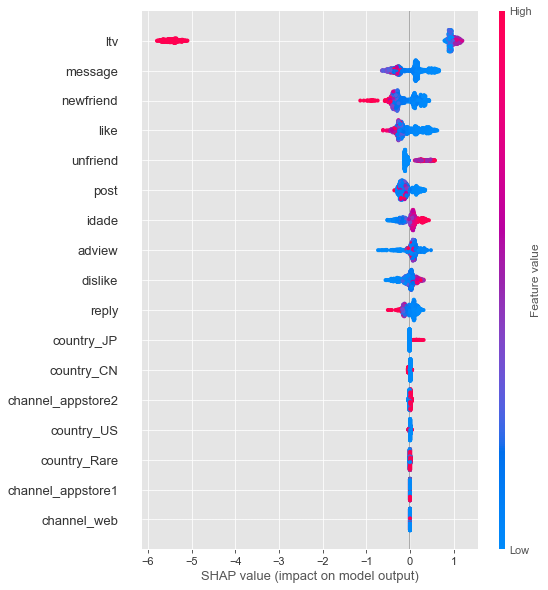

In [59]:
shap.summary_plot(shap_values, X_importance)

#### Análise de Resultados e thresholds

Text(0, 0.5, 'Frequency')

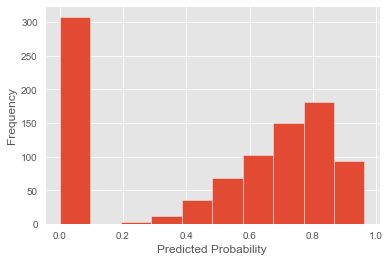

In [61]:
y_pred_proba = model.predict_proba(X_test)
pos_proba = y_pred_proba[:, 1]
plt.hist(pos_proba)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'ROC curve')

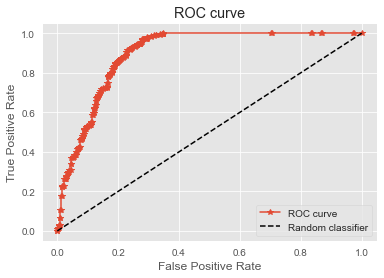

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['ROC curve', 'Random classifier'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

(0.0, 1.0)

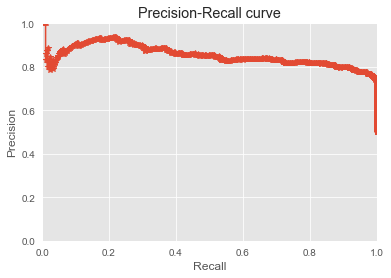

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, '*-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [67]:
print(f'The area under the precision-recall curve is: {auc(recall, precision)}')
print(f'The threshold for the model is {thresholds[-1]}')
print(f'The probability for the model is {pos_proba[-1] > thresholds[-1]}')
print('The AUC Score is: ', roc_auc_score(y_test, pos_proba))

The area under the precision-recall curve is: 0.8528754563938452
The threshold for the model is 0.9629682302474976
The probability for the model is False
The AUC Score is:  0.8964629969634914


#### Thresholds

Best Threshold=0.483571, F-Score=0.862


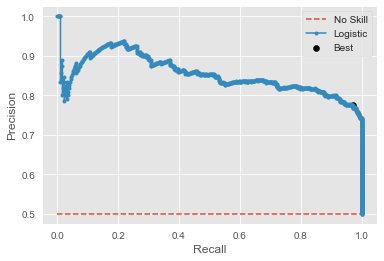

In [68]:
from numpy import argmax


yhat = model.predict_proba(X_test)
yhat = yhat[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [73]:
y_pred_ba=model.predict_proba(X_test)

threshold=best_threshold
pred2=pd.Series(y_pred_ba[:,1]).map(lambda x: 1 if x > best_threshold else 0)
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       476
           1       0.77      0.97      0.86       476

    accuracy                           0.84       952
   macro avg       0.87      0.84      0.84       952
weighted avg       0.87      0.84      0.84       952



In [74]:
confusion_matrix(y_test, pred2)


array([[342, 134],
       [ 15, 461]], dtype=int64)

In [75]:
print(f'Accuracy: {accuracy_score(y_test, pred2)}')
print(f'Precision: {precision_score(y_test, pred2)}')
print(f'Recall: {recall_score(y_test, pred2)}')
print(f'F1: {f1_score(y_test, pred2)}')
print('ROC: %.3f' % roc_auc_score(y_test, pred2, average='micro'))
print(classification_report(y_test, pred2))

Accuracy: 0.8434873949579832
Precision: 0.7747899159663866
Recall: 0.9684873949579832
F1: 0.8608776844070962
ROC: 0.843
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       476
           1       0.77      0.97      0.86       476

    accuracy                           0.84       952
   macro avg       0.87      0.84      0.84       952
weighted avg       0.87      0.84      0.84       952



In [76]:
print(best_threshold)

0.48357117
